<a href="https://colab.research.google.com/github/Rbrut/Sentiment-Analysis/blob/main/Sentiment_Analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries**

In [ ]:
# Libraries
import re
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
import spacy
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.svm import SVC
from tensorflow import keras
from scipy.sparse import vstack
from wordcloud import WordCloud
from sklearn.utils import shuffle
from nltk.corpus import stopwords
from keras.models import Sequential
from matplotlib import pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, confusion_matrix

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Loading dataset**

In [ ]:
# Load the data set
dataFrame = pd.read_csv('IMDB Dataset.csv')
dataFrame.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# **Exploratory Data Analysis**


In [ ]:
dataFrame.shape

(50000, 2)

In [ ]:
dataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
# Null values
dataFrame.isna().sum()

review       0
sentiment    0
dtype: int64

In [ ]:
# Duplicate values
dataFrame.duplicated(subset=['review'], keep='first').sum()

418

In [ ]:
duplicateRows = dataFrame[dataFrame.duplicated()]
duplicateRows

,review,sentiment
3537,Quite what the producers of this appalling ada...,negative
3769,My favourite police series of all time turns t...,positive
4391,"Beautiful film, pure Cassavetes style. Gena Ro...",positive
6352,If you liked the Grinch movie... go watch that...,negative
6479,I want very much to believe that the above quo...,negative
...,...,...
49912,This is an incredible piece of drama and power...,positive
49950,This was a very brief episode that appeared in...,negative
49984,Hello it is I Derrick Cannon and I welcome you...,negative
49986,This movie is a disgrace to the Major League F...,negative


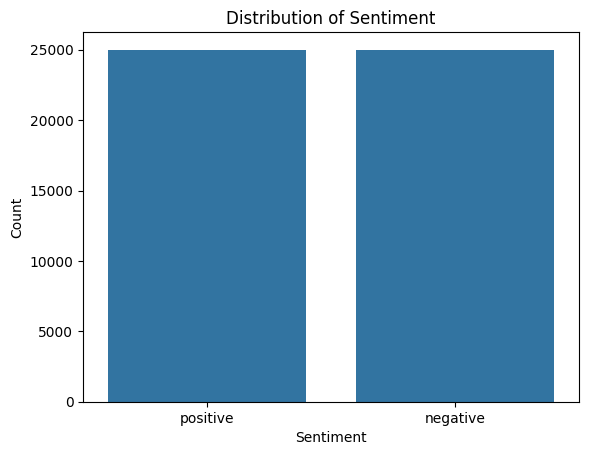

In [ ]:
# Bar chart of sentiment counts
sns.countplot(x='sentiment', data=dataFrame)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiment')
plt.show()

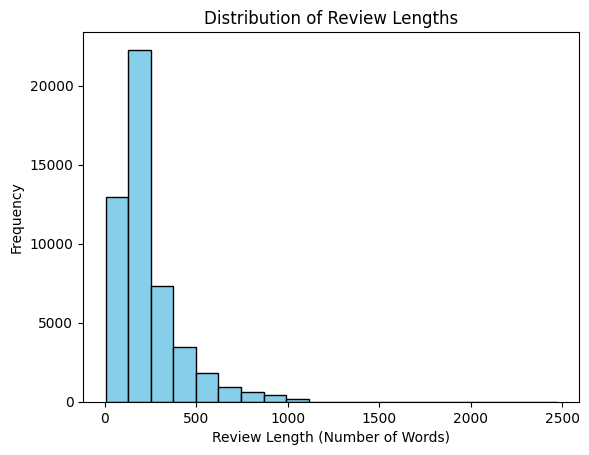

In [ ]:
# Visualizing Review Lengths
review_lengths = dataFrame['review'].apply(lambda x: len(x.split()))
plt.hist(review_lengths, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Review Length (Number of Words)')
plt.ylabel('Frequency')
plt.title('Distribution of Review Lengths')
plt.show()

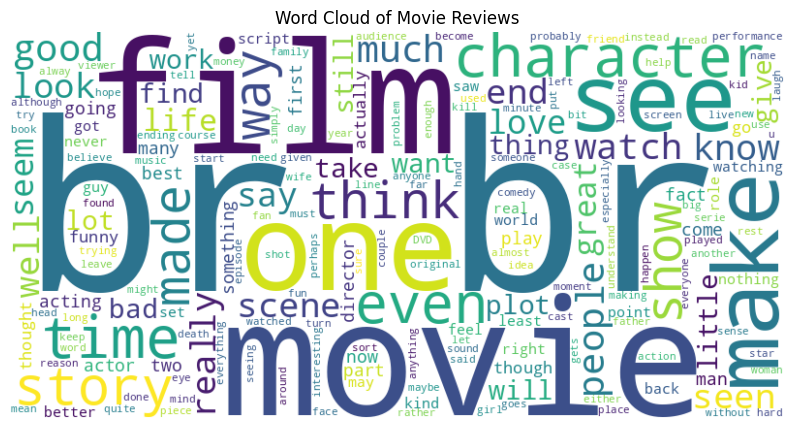

In [ ]:
# Visualizing Word Frequency Distributions (before pre-processing)
all_reviews_text = ' '.join(dataFrame['review'])

# Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Movie Reviews')
plt.show()

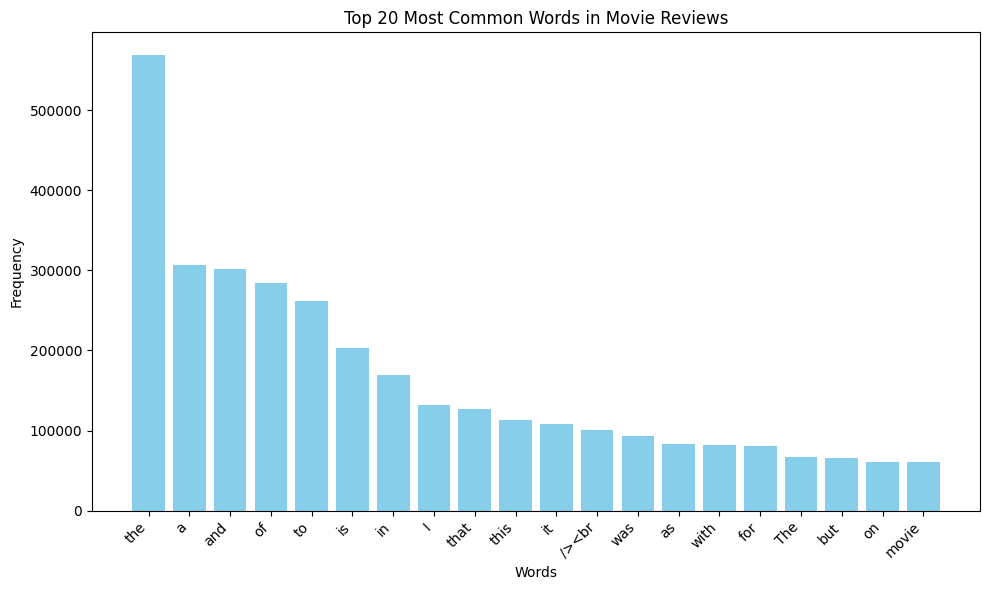

In [ ]:
"""
this part helps in understanding the distribution
of words and identifying the most frequent terms used in the reviews.
"""
from collections import Counter

# Tokenize reviews and count word frequencies
words = all_reviews_text.split()
word_freq = Counter(words)

# Plot bar plot of word frequencies
most_common_words = word_freq.most_common(20)  # Adjust the number of most common words as needed
plt.figure(figsize=(10, 6))
plt.bar(*zip(*most_common_words), color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Common Words in Movie Reviews')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

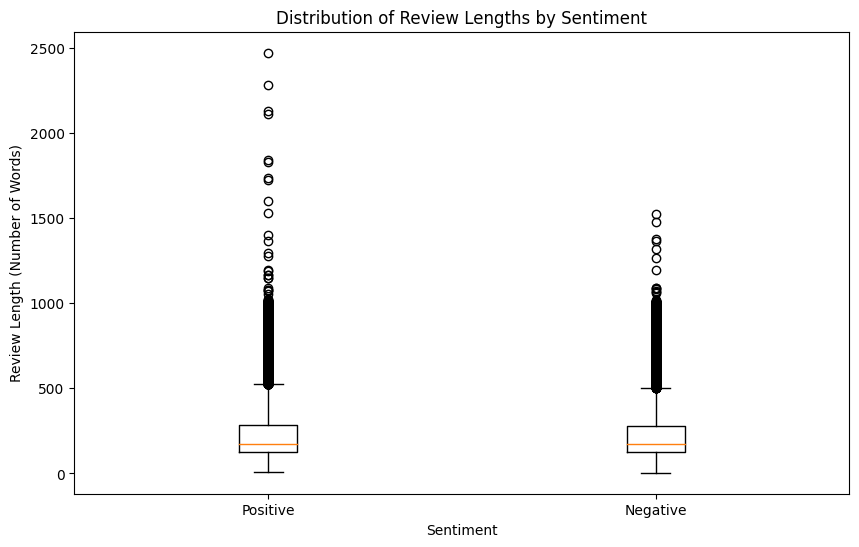

In [ ]:
# Create a box plot of review lengths by sentiment category
dataFrame['review_length'] = dataFrame['review'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.boxplot([dataFrame[dataFrame['sentiment'] == 'positive']['review_length'],
             dataFrame[dataFrame['sentiment'] == 'negative']['review_length']],
            labels=['Positive', 'Negative'])
plt.xlabel('Sentiment')
plt.ylabel('Review Length (Number of Words)')
plt.title('Distribution of Review Lengths by Sentiment')
plt.show()

# **Data Preprocessing**

In [ ]:
#  converting the sentiment text labels to numbers
# (1 for 'positive' and 0 for 'negative') using a lambda function with the apply() method.
dataFrame['sentiment'] = dataFrame['sentiment'].apply((lambda x: 1 if x == 'positive' else 0))

In [ ]:
dataFrame.head()

,review,sentiment,review_length
0,One of the other reviewers has mentioned that ...,1,307
1,A wonderful little production. <br /><br />The...,1,162
2,I thought this was a wonderful way to spend ti...,1,166
3,Basically there's a family where a little boy ...,0,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,230


In [ ]:
nlp = spacy.load("en_core_web_sm")
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocessing(text):
    # Convert to lowercase
    text = text.lower()

    # Remove URLs, user mentions, and hashtags
    text = re.sub(r'http\S+|@\w+|#\w+', '', text)

    # Remove numbers and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize using spaCy for better performance
    tokens = [token.lemma_ for token in nlp(text) if token.text not in stop_words]

    # Lemmatize tokens using WordNetLemmatizer
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join tokens back into a single string
    text = ' '.join(tokens)

    return text

In [ ]:
# Features seclection
data = dataFrame[['review', 'sentiment']]
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
# Peprocessing step
"""
action taken on the review text data:
lowercasing, removing stop words, punctuation, numbers, and special characters,
tokenizing, stemming, and lemmatization
using NLTK, Spacy, and re
"""

data['review'] = data['review'].apply(preprocessing)

<ipython-input-18-dec3686e10de>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['review'] = data['review'].apply(preprocessing)


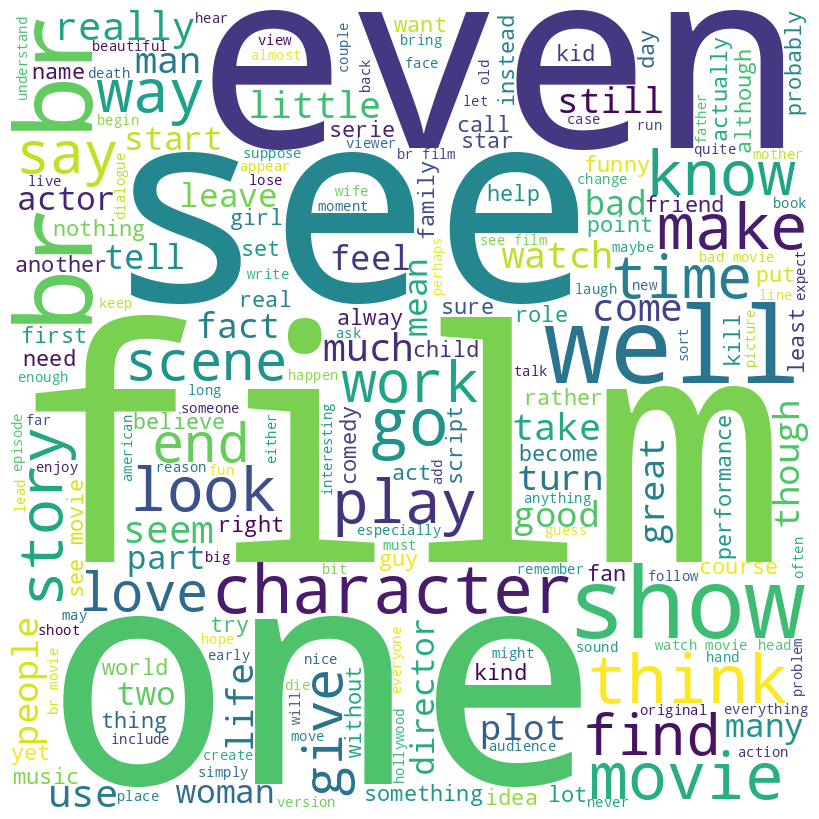

In [ ]:
# Concatenate all the preprocessed tweets into a single string
text = ' '.join(data['review'])
#text = ' '.join(balanced_sample['review'])

# Generate the word cloud
wordcloud2 = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(text)

# Display the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud2)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [ ]:
# Splitting the dataset into training/testing/validation set
data = shuffle(data)
review = data['review']
sentiment = data['sentiment']
train_data, combine_data, train_target, combine_target = train_test_split(review, sentiment, test_size=0.3, random_state=42, stratify=sentiment)
test_data, val_data, test_target, val_target = train_test_split(combine_data, combine_target, test_size=0.5, random_state=42, stratify=combine_target)

In [ ]:
# Vectorization
"""
Vectorization is the process of transforming the
text data into numeric representations so that the data
can be understandable by machine learning algorithms.
We'll use binary vectorization in this project.
"""
# 1. binary vectorization
binary_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 3), stop_words='english' )
# Fit the vectorizer on the training data only
binary_vectorizer.fit(train_data)

# Transform the training, testing, and validation data using the fitted vectorizer
train = binary_vectorizer.transform(train_data)
test = binary_vectorizer.transform(test_data)
val = binary_vectorizer.transform(val_data)

#**Model Seletion**

# **Naive Bayse**

In [ ]:
# Build NB Classifier
NB_classifier = MultinomialNB()

#Train the classifier
NB_classifier.fit(train, train_target)

# Test the classifier
dataTest = vstack([test, val])
test_pred = NB_classifier.predict(dataTest)

In [ ]:
 # Evaluate the model on the testing set
dataTarget = pd.concat([test_target, val_target])
accuracy = accuracy_score(dataTarget, test_pred)
precision = precision_score(dataTarget, test_pred, pos_label=1, average='binary', zero_division=0)
recall = recall_score(dataTarget, test_pred, pos_label=1)
f1 = f1_score(dataTarget, test_pred, pos_label=1)
mse = mean_squared_error(dataTarget, test_pred)

print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))
print("MSE: {:.2f}".format(mse))

Accuracy: 0.90
Precision: 0.91
Recall: 0.88
F1-score: 0.89
MSE: 0.10


In [ ]:
print("Classification Report:")
print(classification_report(dataTarget, test_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.90      7500
           1       0.91      0.88      0.89      7500

    accuracy                           0.90     15000
   macro avg       0.90      0.90      0.90     15000
weighted avg       0.90      0.90      0.90     15000



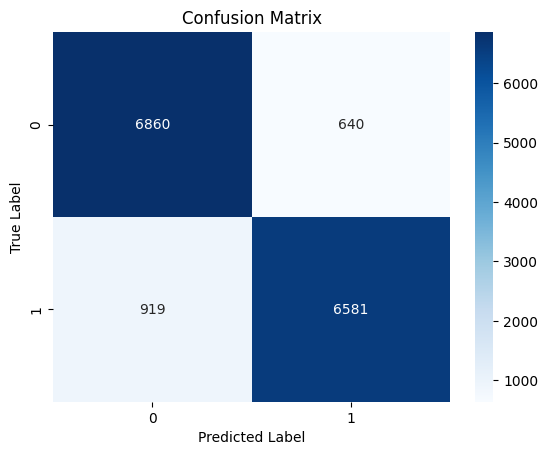

In [ ]:
# Create confusion matrix
confusionMatrix = confusion_matrix(dataTarget, test_pred)

# plot confusion matrix
sns.heatmap(confusionMatrix, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# **SVM**

In [ ]:
# Build SVM Classifier
SVM_classifier = SVC(kernel='linear', random_state=42)

# Train the classifier
SVM_classifier.fit(train, train_target)

# Evaluate the classifier
SVM_pred = SVM_classifier.predict(val)

In [ ]:
 # Evaluate the model
SVM_accuracy = accuracy_score(val_target, SVM_pred)
SVM_precision = precision_score(val_target, SVM_pred, pos_label=1, average='binary', zero_division=0)
SVM_recall = recall_score(val_target, SVM_pred, pos_label=1)
SVM_f1 = f1_score(val_target, SVM_pred, pos_label=1)
SVM_mse = mean_squared_error(val_target, SVM_pred)

print("Accuracy: {:.2f}".format(SVM_accuracy))
print("Precision: {:.2f}".format(SVM_precision))
print("Recall: {:.2f}".format(SVM_recall))
print("F1-score: {:.2f}".format(SVM_f1))
print("MSE: {:.2f}".format(SVM_mse))

In [ ]:
print("Classification Report:")
print(classification_report(val_target, SVM_pred))

In [ ]:
# Create confusion matrix
SVM_confusionMatrix = confusion_matrix(val_target, SVM_pred)

# plot confusion matrix
sns.heatmap(SVM_confusionMatrix, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [ ]:
# Hyper parameter tuning
svm_params = {'kernel': ['linear', 'rbf', 'sigmoid', 'precomputed'], 'C': [0.1, 1, 5, 10, 15, 20], 'gamma': ['scale', 'auto']}

svm_grid = GridSearchCV(SVM_classifier, svm_params, cv=5, scoring='accuracy', error_score='raise')

svm_grid.fit(val, val_target)

# Get the best hyperparameters
SVM_best_params = svm_grid.best_params_
print("Best Hyperparameters:", SVM_best_params)

# Get the best model
best_model = svm_grid.best_estimator_

In [ ]:
# Fit the best model on the validation set
best_model.fit(val, val_target)

# Evaluate the best model on the testing set
test_accuracy = best_model.score(test, test_target)
print("Test Accuracy:", test_accuracy)

# **Neural Network (LSTM)**

In [ ]:
# Vectorization
# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data)

# Convert text to sequences of integers
train_sequences = tokenizer.texts_to_sequences(train_data)
test_sequences = tokenizer.texts_to_sequences(test_data)
val_sequences = tokenizer.texts_to_sequences(val_data)

# Pad sequences to ensure uniform length
max_sequence_length = max([len(seq) for seq in train_sequences + test_sequences + val_sequences])
train_sequences_padded = pad_sequences(train_sequences, maxlen=max_sequence_length)
test_sequences_padded = pad_sequences(test_sequences, maxlen=max_sequence_length)
val_sequences_padded = pad_sequences(val_sequences, maxlen=max_sequence_length)

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1
# Maximum sequence length
max_length = max(len(seq) for seq in train_sequences_padded)


model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_length))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display model summary
print(model.summary())

In [ ]:
# Train the model
history = model.fit(train_sequences_padded, train_target, epochs=5, batch_size=32, validation_split=0.2)

# Validate the model
loss, accuracy = model.evaluate(val_sequences_padded, val_target)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

In [ ]:
# Hyper parameter tuning
# Define a function to create the LSTM model
def create_lstm_model(units=100, dropout_rate=0.2):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_length))
    model.add(SpatialDropout1D(dropout_rate))
    model.add(LSTM(units))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Create KerasClassifier
model = KerasClassifier(build_fn=create_lstm_model, epochs=5, batch_size=32, verbose=0)

# Define the hyperparameters grid to search
param_grid = {
    'units': [50, 100, 150],
    'dropout_rate': [0.2, 0.3, 0.4]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_search_result = grid_search.fit(train_sequences_padded, train_target)

# Print the best parameters and corresponding accuracy
print("Best Parameters: ", grid_search_result.best_params_)
print("Best Accuracy: ", grid_search_result.best_score_)

# Validate the model with best parameters
best_model = grid_search_result.best_estimator_.model
loss, accuracy = best_model.evaluate(val_sequences_padded, val_target)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

In [ ]:
# Test the model
predictions = model.predict(test_sequences_padded)
predicted_labels = (predictions > 0.5).astype(int)

# Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix

# Convert predictions to 1D array
predictions = predictions.flatten()

# Print classification report
print(classification_report(test_target, predicted_labels))

# Print confusion matrix
print(confusion_matrix(test_target, predicted_labels))